<a href="https://colab.research.google.com/github/contrerasisaac/Intro_to_ML/blob/main/CV_System_Model_(YOLO%20Algorithm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introduction

**Note**: Remember to change your runtime type to use GPU. This will accelerate the training later on.

In this notebook, you will **fine-tune** the YOLO version 5 model to detect between two classes from your webcam.

As an example, we'll demonstrate a facial recognition task, detecting your face when it is awake versus drowsy. However, feel free to choose two of your own classes or objects. Here are some ideas you can consider:

- Drowsiness detection
- Person identification
- Gesture recognition - hand signals/body position
- Emotion recognition
- Mask detection - COVID
- Pet detection

Fine-tuning in machine learning refers to the process of taking a pre-trained model (usually trained on a large dataset for a related task) and further training it on a smaller dataset specific to the target task. The goal is to leverage the knowledge already present in the pre-trained model and adapt it to perform well on the new task.

## YOLO Algorithm

YOLO (You Only Look Once) is a popular object detection model in computer vision. It was introduced in a 2015 [research paper](https://arxiv.org/pdf/1506.02640.pdf) by Joseph Redmon, Santosh Divvala, Ross Girshick, and Ali Farhadi.

Traditional object detection approaches involve running a region proposal algorithm (like selective search) followed by a separate classifier to determine the object class within each proposed region. These methods can be slow and computationally expensive.

In contrast, YOLO takes a different approach. It divides the input image into a grid and predicts bounding boxes and class probabilities directly from each grid cell. The grid cells allow the model to make predictions for multiple objects in different spatial locations simultaneously. This way, the detection process becomes much faster and more efficient.

Key features of YOLO include:

- Single Forward Pass: YOLO performs object detection in a single forward pass through the neural network, making it extremely fast compared to multi-stage methods.

- Unified Framework: YOLO unifies object detection and classification into a single neural network, which leads to better generalization and end-to-end optimization.

- Objectness Score: The model predicts an "objectness" score for each bounding box, indicating how likely the box contains an object. This helps YOLO focus on relevant regions and ignore empty areas.

- Real-Time Detection: YOLO is designed for real-time applications and can achieve impressive frame rates even on relatively low-end hardware.

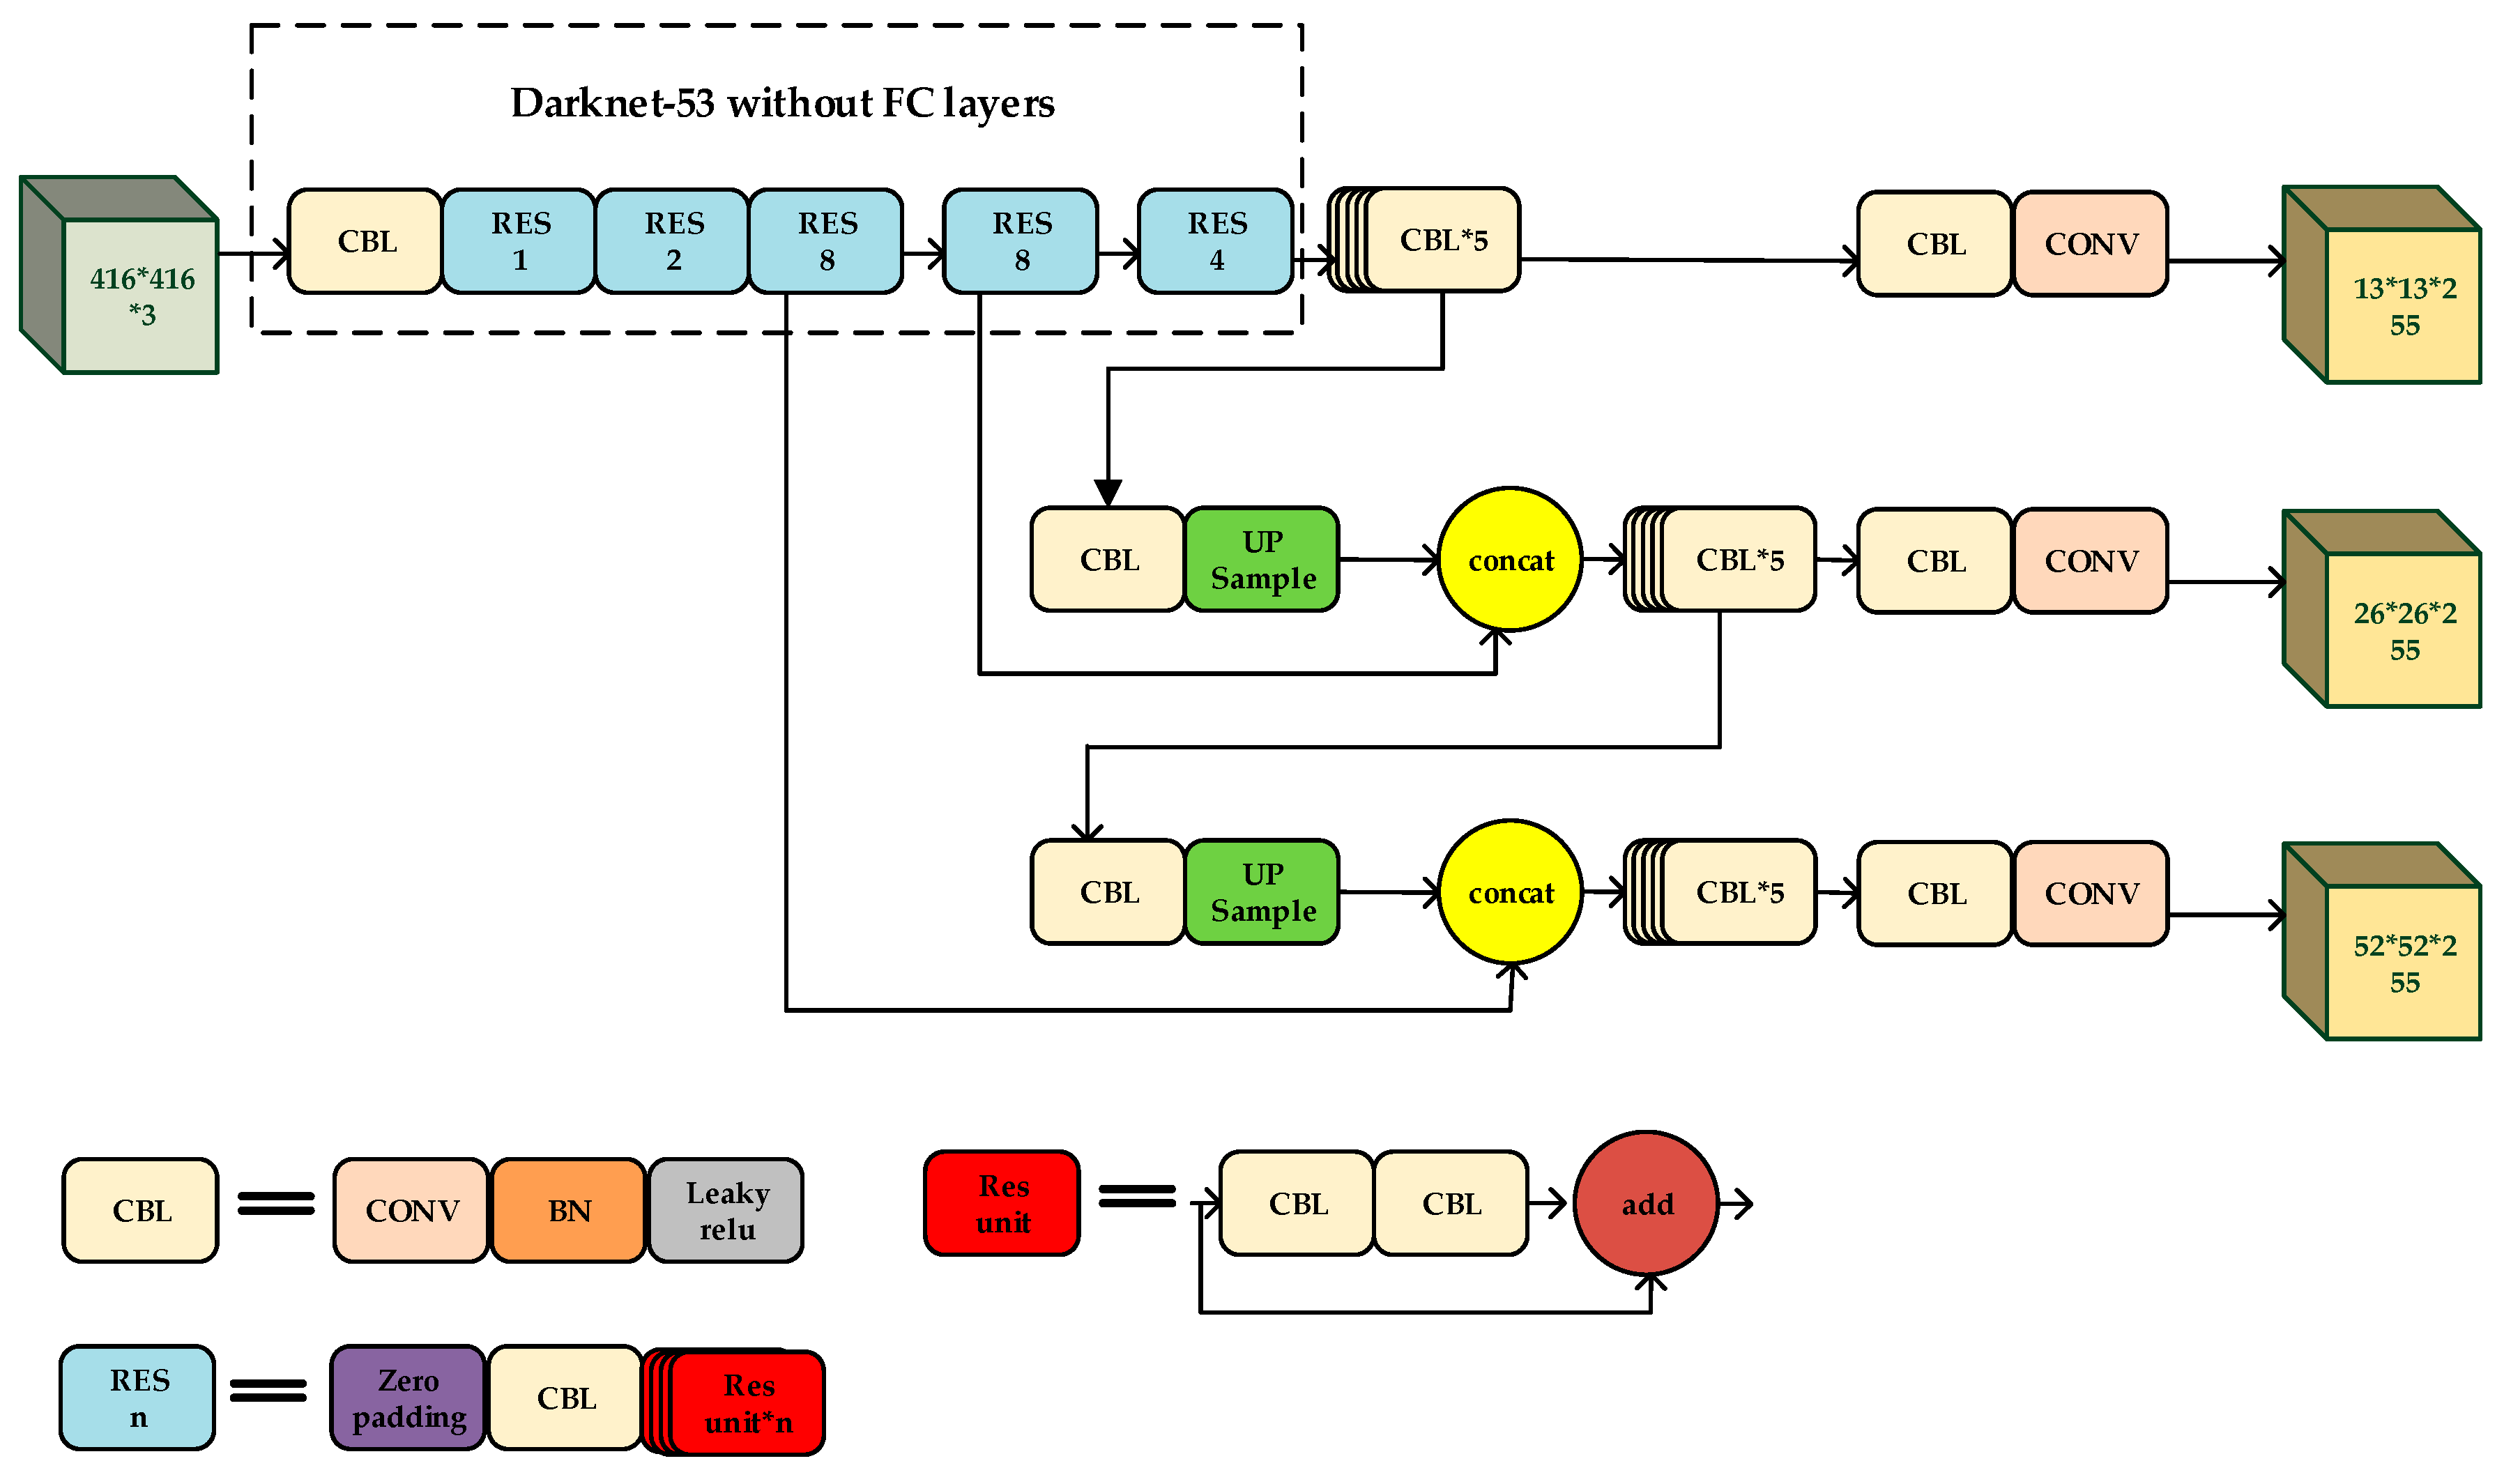

# 2. Install and Import Dependencies

Run the following cells to import the required modules and libraries. You will also clone into the yolov5 repository from ultraytics.

In [ ]:
# https://pytorch.org/get-started/locally/
!pip3 install torch torchvision torchaudio

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15845, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 15845 (delta 31), reused 39 (delta 13), pack-reused 15768
Receiving objects: 100% (15845/15845), 14.66 MiB | 24.81 MiB/s, done.
Resolving deltas: 100% (10843/10843), done.


In [ ]:
!pip install -r yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2

# 3. Load Model

Next, let's load the pretrained model. Look at the documentation here for hints on how to do this: https://github.com/ultralytics/yolov5

In [ ]:
model = torch.hub.load("ultralytics/yolov5", "yolov5s")  # or yolov5n - yolov5x6, custom

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-7-31 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 127MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


The following cell displays the structure of the model we're working with. Don't worry about any of the details.

In [ ]:
print(model)

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# 4. Make Detections with Images

Now that we've loaded the model, let's see what it's capable of. Here's an example:

In [ ]:
img = 'https://p1.pxfuel.com/preview/890/123/692/new-york-highline-skyline-city.jpg'

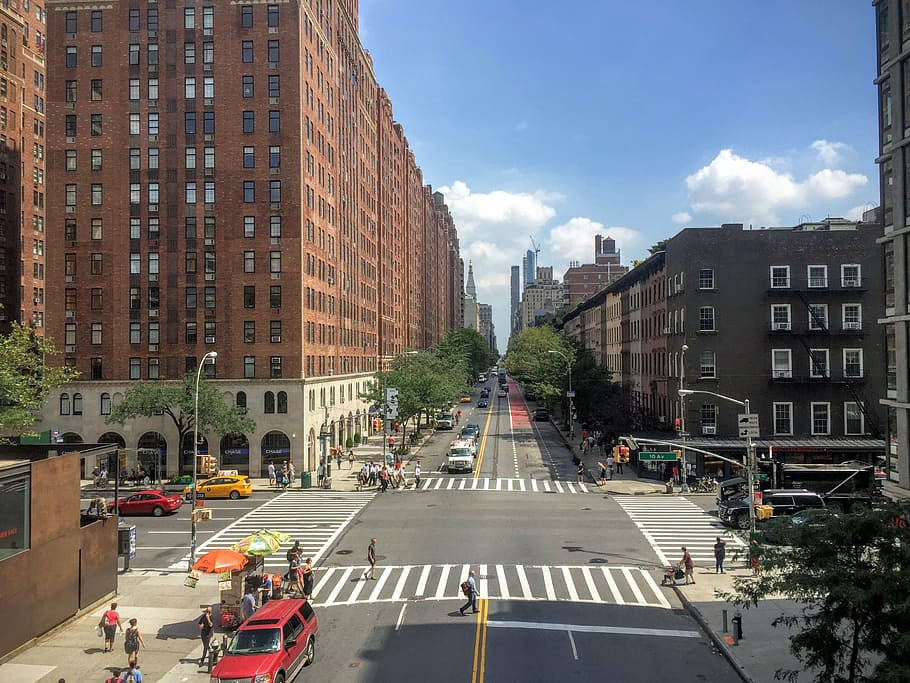

In [ ]:
import requests
from IPython.display import Image

response = requests.get(img)

if response.status_code == 200:
    with open("example.jpg", "wb") as f:
        f.write(response.content)

    display(Image("example.jpg"))
else:
    print("Failed to download the image. Status code:", response.status_code)

In [ ]:
results = model(img)
results.print()

image 1/1: 683x910 11 persons, 9 cars, 2 umbrellas
Speed: 877.3ms pre-process, 435.0ms inference, 52.2ms NMS per image at shape (1, 3, 480, 640)


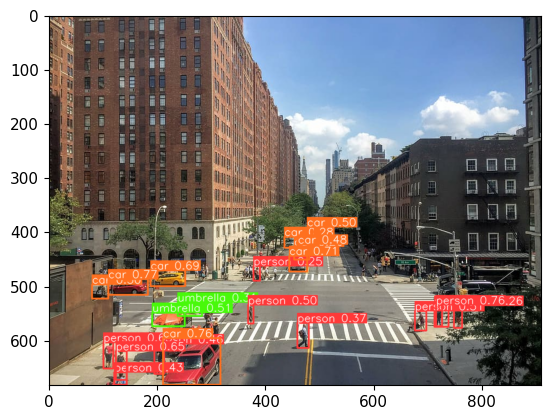

In [ ]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

Now try it yourself! Search the web for a photo you'd like to test the model on. Paste the url to the image below.

In [ ]:
img = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/New_york_times_square-terabass.jpg/1200px-New_york_times_square-terabass.jpg'

In [ ]:
results = model(img)
results.print()

image 1/1: 800x1200 4 persons, 3 cars
Speed: 278.5ms pre-process, 50.9ms inference, 1.5ms NMS per image at shape (1, 3, 448, 640)


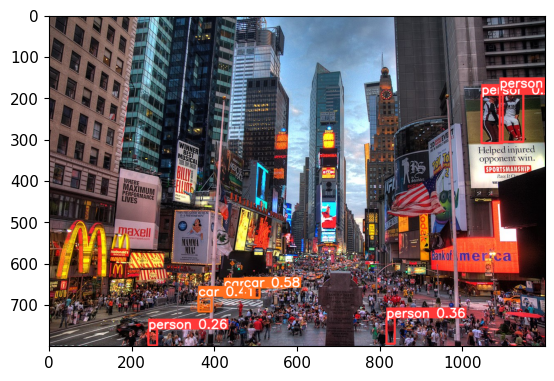

In [ ]:
%matplotlib inline
plt.imshow(np.squeeze(results.render()))
plt.show()

# 5. Connecting to Webcam

Now let's connect to your webcam to start making your own unique dataset. The following code defines a function `take_photo` in Javascript.

In [ ]:
import os
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Let's try taking a photo of ourselves and seeing what YOLO classifies us as.

<IPython.core.display.Javascript object>

Saved to photo.jpg


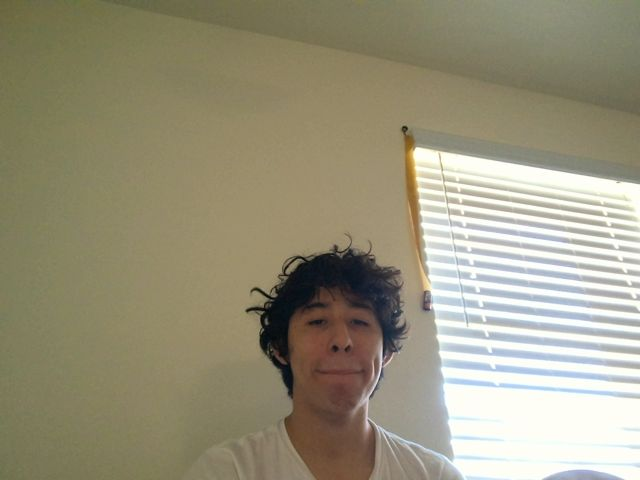

In [ ]:
from IPython.display import Image
try:
  filename = take_photo(filename='photo.jpg', quality=0.8)
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

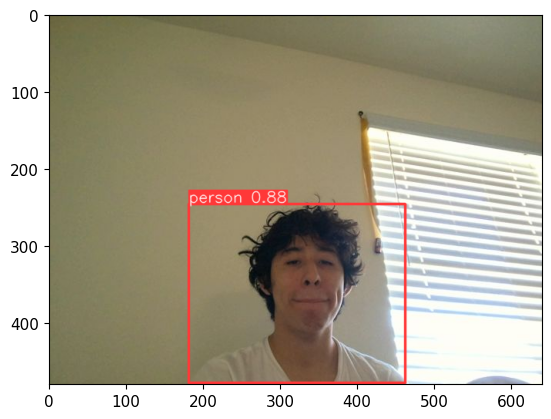

In [ ]:
img = os.path.join('photo.jpg')
results = model(img)
plt.imshow(np.squeeze(results.render()))
plt.show()

Hopefully you've been classified as a person!

# 6. Generate the Data

Now we will generate our own data in order to fine tune the model. Let's train a model to detect when we are awake versus when we are drowsy. Here is a quick overview of the plan:
1. Take a bunch of pictures of yourself awake and drowsy
2. Store the pictures in the `data/images` path
3. Download the data
4. Label the data using [cvat.ai](https://www.cvat.ai/)

Begin by importing relevant Python modules.

In [ ]:
import uuid # Unique identifier for each image file
import os
import time

Next, let's set up the file paths. This is very important! Note, make sure `CLEAR_DATA` is set to False in all cases, except for when you want to restart and delete the pictures you've taken so far.

In [ ]:
CLEAR_DATA = False
if CLEAR_DATA and os.path.isdir('data'):
  !rm -r data
if not os.path.isdir('data'):
  os.mkdir('data')
  os.mkdir('data/images')
  os.mkdir('data/labels')
labels = ['awake', 'drowsy'] # Your code here - replace these labels with your desired classes

Next, let's begin creating our dataset. Follow the instructions and take pictures of yourself / the relevant objects according to your chosen two classes.

Some things to note before creating your data:
- try to have a variety of different backgrounds while taking these pictures
- take pictures at different angles
- put your head in different parts of the frame
- have different facial expressions within the same class

Following these guidelines will ensure that your model can generalize more to unseen images.



In [ ]:
number_imgs = 20

In [ ]:
DISPLAY_IMAGE = False
for label in labels:
    print('Collecting images for \033[1m{}\033[0m'.format(label))
    time.sleep(2)
    for img_num in range(number_imgs):
        print('Collecting images for \033[1m{}\033[0m, image number \033[94m{}\033[0m'.format(label, img_num))

        imgname = 'data/images/' + f"{label}." + str(uuid.uuid1()) + '.jpg'

        take_photo(imgname)

        if DISPLAY_IMAGE: display(Image(filename))

        time.sleep(0.25)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, let's download the data. Note that it may take a minute for the `data` folder to show up in your files.

You can access your files by clicking on the file tab on the right.

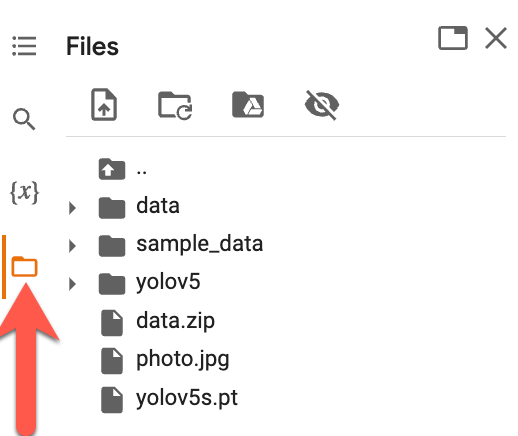

In [ ]:
# Zips the folder

!zip -r data.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/labels/ (stored 0%)
  adding: content/data/images/ (stored 0%)
  adding: content/data/images/drowsy.4da6afd0-2fd0-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/awake.6b7b2910-2fcf-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/awake.eaf318f6-2fcf-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/awake.707269c4-2fcf-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/drowsy.2a7ecf56-2fd0-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/awake.6f3ee9a6-2fcf-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/drowsy.3e10fc4c-2fd0-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/awake.612bc28a-2fcf-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/drowsy.4ba3dd20-2fd0-11ee-9d0e-0242ac1c000c.jpg (deflated 1%)
  adding: content/data/images/drowsy.2eb63424-2fd0-11ee

Now that you have a `data.zip` folder, download it. Verify that it contains the images you took.

# 7. Annotate the Data

Now that we have our data, we need to annotate it! **It is not as simple as just labeling each image according to our class, since we need to find the specific bounding box of each object.**

The next part of this notebook is the trickiest. Go to [cvat.ai](https://app.cvat.ai/auth/login?next=/tasks), and create a free account.

Once you log in, you should see a page that looks something like this:

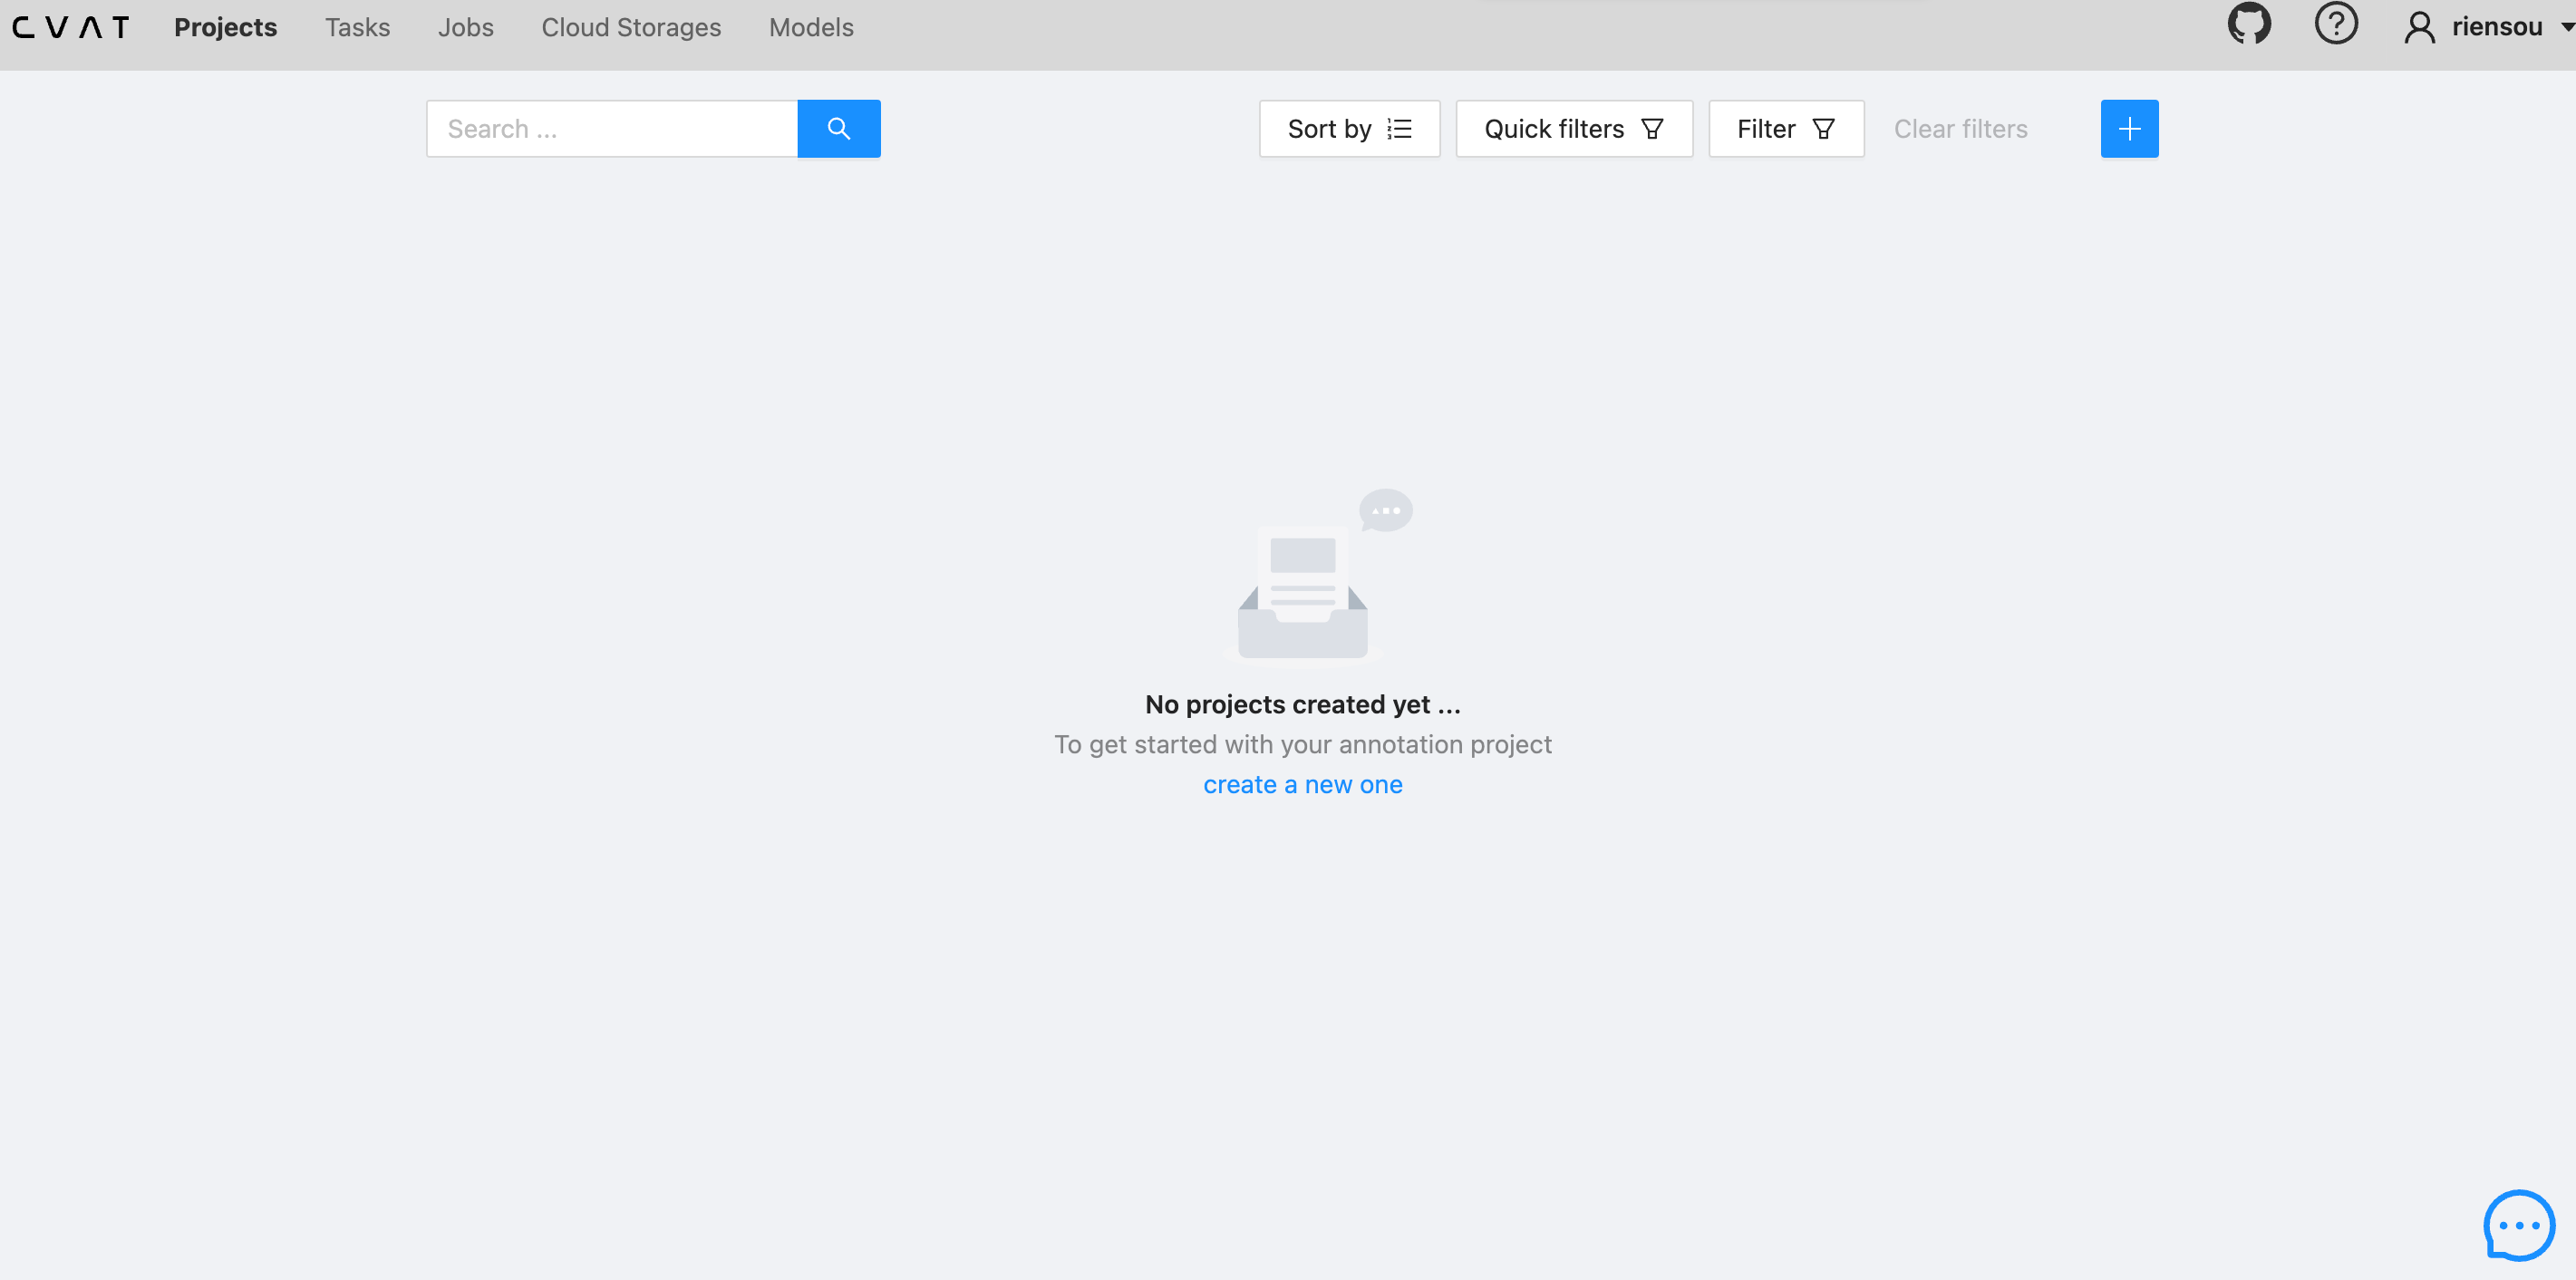

Next, go to the `Tasks` page. Press the `+` button at the top right, and create a new task.

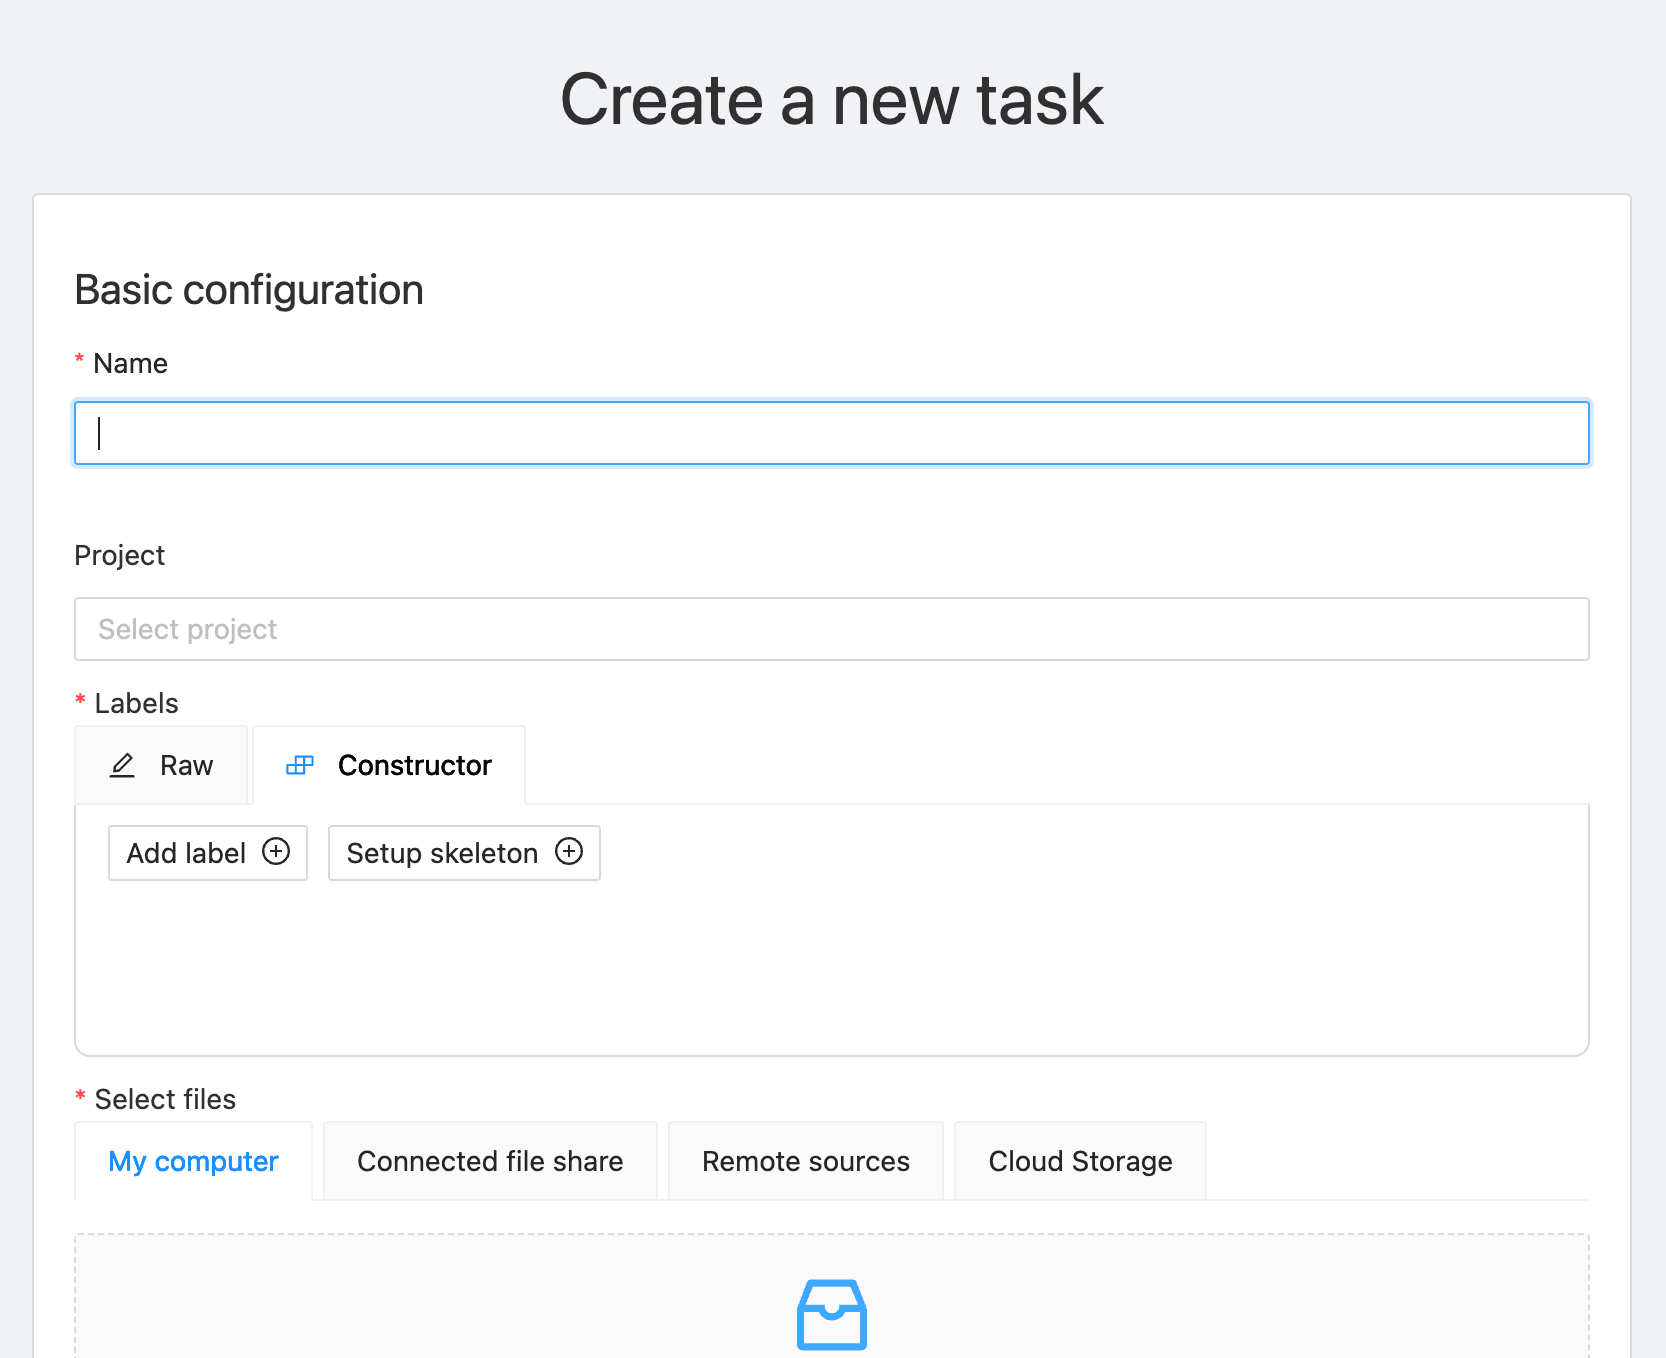

Next, add all of your images downloaded earlier.

Finally, click 'Advanced configuration' and scroll to where it says 'Choose format'. Select `YOLO 1.1`. This will ensure that the labels are generated using the proper format.

Press 'Submit & Continue'.

Once you're done labelling every image, save your changes, and go to `Menu>Export job dataset`. Select `YOLO 1.1` for the export format and then press 'OK'.

Open the zip folder that you download and you should see 4 things:
- obj_train_data (folder)
- obj.data (file)
- obj.names (file)
- train.txt (file)

For each file in the obj_train_data folder, you should see something like this:

`0 0.150391 0.561427 0.291906 0.861396`,

where the first number corresponds to the label number (awake or drowsy) and the next four numbers correspond to the corners of the rectangle that you labeled.

Next, upload all of the files in the obj_train_data folder into the google colab files in the `data/labels` directory. After this step, your `data/labels` directory should have as many files are your `data/images` directory.



In [ ]:
num_files_in_images = len([entry for entry in os.listdir('data/images') if os.path.isfile(os.path.join('data/images', entry))])
num_files_in_labels = len([entry for entry in os.listdir('data/labels') if os.path.isfile(os.path.join('data/labels', entry))])
if num_files_in_images == num_files_in_labels:
  print("Success: you have an equivalent amount of files in data/images and data/labels")
else:
  print("Error: you have a different number of files in data/images and data/labels")

Error: you have a different number of files in data/images and data/labels


Congratulations! You have successfully created, labeled, and uploaded training data and labels! You are almost ready to fine tune the model.

The final step is to create a file called `dataset.yml` that will tell our model what and where our data and labels are. In a code editor / text editor such as Visual Studio code, create a file called `dataset.yml` with the following entries.

**Note:** Make sure the order in which you label in the dataset.yml matches the order in which you annotated earlier (e.g 0 for drowsy, 1 for awake), or else your model will output the opposite of what you'd like.

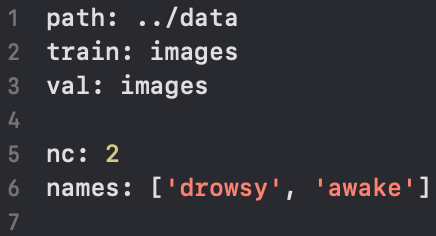

Then, upload `dataset.yml` and place it inside the `yolov5` folder.

# 8. Train the model

We will now **fine tune** the `yolov5` model on our new training data.

In order to do this, we will use Ultralytic's (the team behind YOLOv5) custom script. Why would they create a custom script rather than default to Pytorch's training methods?

* Loading a YOLOv5 model with a specified architecture (yolov5s, yolov5m, etc.)
* Applying specific data augmentation techniques useful for object detection.
* Computing the loss function used in YOLO, which is different from typical classification or regression losses.
* Applying specific learning rate schedules.
* Logging the training process with rich visualizations.


It may take a long time to run for a large number of epochs.

For reference, 500 epochs will take about 20-25 minutes to run. The amount of epochs that you need to run will depend on the difficulty of your task. For a drowsy vs awake model, it tends to take in the low hundreds of epochs before performing adequately.

Note that we chain the terminal commands with "&&" since in Colab, bash commands are immediately lost in the runtime.

Here are the specific configurations that we'd like:


* Set the training script to fine-tune from pre-trained weights of yolov5s.pt
* Set the data to be configured based on our dataset.yml
* Set the number of workers to 2
* Set the img-size hyperparameter to 320px
* Set the batch size hyperparameter to 16
* Set the epochs hyperparameter to 500

Check in with me once you think your command is correct!

In [ ]:
# Uncomment the command below to see an explanation of the parameters to train.py

# !cd yolov5 && python train.py --help

In [ ]:
!cd yolov5 && # Your code here


train: weights=yolov5s.pt, cfg=, data=dataset.yml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-198-g34c2187 Python-3.10.6 torch-2.0.1+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0

Congratulations! You have fine tuned the `yolov5` model! Now copy and paste the path it saved the results to in the following cell to load our newly fine-tuned model.

In [ ]:
path = # Your code here

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/' + path + '/weights/best.pt', force_reload=True)


# 9. Testing the model

Let's take a new photo and test our model.

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  results = model(filename)
  print(results)
  plt.imshow(np.squeeze(results.render()))
  plt.show()
except Exception as err:
  print(str(err))

Now let's test our model on all of our training data to see how well we fit to the our original data.

In [ ]:
for img in os.listdir('data/images/'):
  if not os.path.isdir(img):
    results = model('data/images/'+img)
    print(results)
    plt.imshow(np.squeeze(results.render()))
    plt.show()

Note that for the sake of simplicity, when we fine-tuned the model, we did not gauge performance on a validation set and rather used the training set only, which may be susceptible to overfitting!

For optimal performance, it'd be good practice to gather and annotate significantly more data points, and optimize hyperparameters via cross validation.

Think about the ways you can expand the project into something bigger using YOLO. Object detection is a very powerful tool. Some ideas... (can maybe also consider for your final project!)

- Facial - expression based game control
- Home security system
- Traffic monitor
- Assisted living emergency detection for the elderly
- ... and more

# 10. Addendum: Real-time detection

YOLO is an incredibly efficient model, so much so that you can run inference in real time.

Think about how you might modify the `take_photo` function to automatically take a photo without clicking a button. Then, use this in a loop to repeatedly take photos. Pass these photos into the model and display the output to the user. Now you have a real-time model!

Here's another method that takes in a video stream directly. However, this does not work on Colab, so you'll have to install Jupyter notebook locally to run this.

In [ ]:
# Does not work on colab, only works in local Jupyter notebooks

# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()

#     # Make detections
#     results = model(frame)

#     cv2.imshow('YOLO', np.squeeze(results.render()))

#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()